# Credit Card Fraud

Credit card fraud is a problem that finance companies which offer consumers credit cards would like to eliminate. Since there are around 1 billion credit card transactions which take place every day, manually flagging and cancelling fraudulent transactions is entirely unfeasible. With machine learning, we can train a computer to distinguish fraudulent transactions from real ones using previous examples. This protects the company from liability and loss and also reduces operating costs.

The following dataset is from Kaggle (https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud). The dataset contains transactions made with credit cards by European cardholders in September 2013. The data has gone through dimensionality reduction via PCA, which anonymizes the data and also makes it easier for a machine learning model to learn from. 

The only features which remain untransformed are the 'Time' and 'Amount' features. The 'Time' column contains the seconds elapsed between each transaction and the first transaction in the dataset. The 'Amount' feature is the transaction amount. Finally, the 'Class' feature is the target variable, with '1' being a fraudulent transaction and 0 otherwise.

The dataset author recommends: 
> Given the class imbalance ratio, we recommend measuring the accuracy using the Area Under the Precision-Recall Curve (AUPRC). Confusion matrix accuracy is not meaningful for unbalanced classification.

In [11]:
%matplotlib inline
import matplotlib.pyplot as plt
import os
import pandas as pd
import numpy as np
import seaborn as sns

CREDIT_CARD_FILENAME = 'creditcard.csv'
RANDOM_STATE = 3
    
def load_credit_card_data(file_path=CREDIT_CARD_FILENAME):
    csv_path = os.path.join('data', file_path)
    return pd.read_csv(csv_path)

credit_card = load_credit_card_data()

In [2]:
credit_card.head(5)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [6]:
print('Frequencies')
print(credit_card.value_counts('Class'))

Frequencies
Class
0    284315
1       492
dtype: int64


We can see how unbalanced the class ratio is, and we can see above that each feature is V1-V28.

array([[<AxesSubplot:title={'center':'Class'}>]], dtype=object)

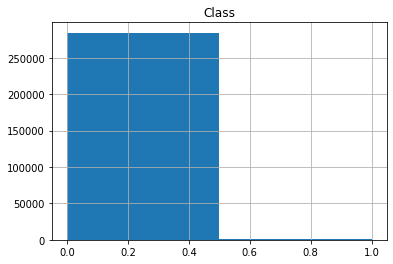

In [9]:
credit_card.hist('Class', bins=2)